# Random Forest vs. LIME

## Data Acquisition 

+ For more about data processing and exploratory data analysis, please direct to the EDA notebook

In [1]:
# Load Modules 
import pandas as pd
import sklearn.ensemble
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection
import numpy as np
from sklearn.model_selection import train_test_split
import lime
import lime.lime_tabular

In [2]:
# Load Data
dat = pd.read_csv('CCmerge_10Kobs_1479_1530.csv')

# drop column j, train, validation, test
# Re-do it later
dat = dat.drop(columns='j')

# Use all variables to predict units sales 
# Remove variable UPC, Week, dollars, store id
dat = dat.drop(columns=['UPC', 'week','DOLLARS', 'iri_key'])

In [3]:
# Know your data
print('The shape of our data is: ', dat.shape)

The shape of our data is:  (11021, 11)


In [4]:
dat.describe()

,UNITS,pr,d,vol_eq,price,price_pr
count,11021.000000,11021.000000,11021.000000,11021.000000,11021.000000,11021.000000
mean,12.165411,0.247255,0.090010,0.988367,3.427420,0.677041
std,24.724492,0.431436,0.390996,0.317896,1.039454,1.244234
min,0.000000,0.000000,0.000000,0.039100,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.800000,2.625000,0.000000
50%,6.000000,0.000000,0.000000,0.937500,3.490000,0.000000
75%,13.000000,0.000000,0.000000,1.125000,4.090000,0.000000
max,901.000000,1.000000,2.000000,4.000000,14.140000,6.220000


In [5]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11021 entries, 0 to 11020
Data columns (total 11 columns):
UNITS          11021 non-null int64
package        11021 non-null object
flavorscent    11021 non-null object
typeofgrain    11021 non-null object
pr             11021 non-null int64
f              11021 non-null object
d              11021 non-null int64
brand          11021 non-null object
vol_eq         11021 non-null float64
price          11021 non-null float64
price_pr       11021 non-null float64
dtypes: float64(3), int64(3), object(5)
memory usage: 947.2+ KB


In [6]:
# Change Data type -- continous
dat.UNITS = dat.UNITS.astype('float64')

In [7]:
# View Data
dat.head()

,UNITS,package,flavorscent,typeofgrain,pr,f,d,brand,vol_eq,price,price_pr
0,5.0,BOX,CINNAMON TOAST,WHOLE WHEAT AND RICE,0,NONE,0,GENERAL MILLS CINNAMON TST CR,0.0625,0.50,0.0
1,2.0,BOX,TOASTED,WHOLE GRAIN OAT,0,NONE,0,GENERAL MILLS CHEERIOS,0.0391,0.50,0.0
2,5.0,BOX,HONEY NUT,WHOLE GRAIN OAT,0,NONE,0,GENERAL MILLS HONEY NUT CHEER,0.0508,0.48,0.0
3,1.0,CUP,HONEY NUT,WHOLE GRAIN OAT,0,NONE,0,GENERAL MILLS HONEY NUT CHEER,0.1125,1.19,0.0
4,2.0,CUP,HONEY NUT,WHOLE GRAIN OAT,0,NONE,0,GENERAL MILLS HONEY NUT CHEER,0.1125,1.19,0.0


## Data Preparation

### Remove Outliers

In [8]:
# Remove Outlier (Look at the eda)
q = dat.UNITS.quantile(0.98)
dat = dat[(dat.UNITS > 0) & (dat.UNITS < q)]

### Reduce Features

In [9]:
# Reduce feature
# Contain only company name
dat['brand'] = pd.np.where(dat.brand.str.contains("GENERAL"), "GENERAL MILLS",
                   pd.np.where(dat.brand.str.contains("KELLOGGS"), "KELLOGGS",
                   pd.np.where(dat.brand.str.contains("QUAKER"), "QUAKER",
                   pd.np.where(dat.brand.str.contains("POST"), "POST",
                               "OTHER_BRAND"))))

### Creating Categorized Variable -- One-Hot Encoding

In [10]:
# Create an empty list 
dummy = list()

# feature value
for i in dat.iloc[:, [1,2,3,5,6,7]].columns:
    df = pd.get_dummies(dat[i])
    dummy.append(df)

In [11]:
# Rename the column name for pr dummy and d dummy 

dummy[3].columns = ['Feature_A','Feature_A+', 'Feature_B', 'Feature_C', 'Feature_NONE']
dummy[4].columns = ['Display_0', 'Display_1', 'Display_2']

In [12]:
# replace the dummy variables in the original dataset

dat = dat[['UNITS', 'vol_eq', 'price', 'price_pr','pr']]

for i in range(0,6):
    dat = dat.merge(dummy[i], left_index=True, right_index=True)


In [13]:
# View Data 
dat.head()

,UNITS,vol_eq,price,price_pr,pr,BAG,BOX,CUP,PLASTIC BAG,RESEALABLE BAG,...,Feature_C,Feature_NONE,Display_0,Display_1,Display_2,GENERAL MILLS,KELLOGGS,OTHER_BRAND,POST,QUAKER
0,5.0,0.0625,0.50,0.0,0,0,1,0,0,0,...,0,1,1,0,0,1,0,0,0,0
1,2.0,0.0391,0.50,0.0,0,0,1,0,0,0,...,0,1,1,0,0,1,0,0,0,0
2,5.0,0.0508,0.48,0.0,0,0,1,0,0,0,...,0,1,1,0,0,1,0,0,0,0
3,1.0,0.1125,1.19,0.0,0,0,0,1,0,0,...,0,1,1,0,0,1,0,0,0,0
4,2.0,0.1125,1.19,0.0,0,0,0,1,0,0,...,0,1,1,0,0,1,0,0,0,0


## Train and Validate the Random Forest Model 

### Create Training and Testing set

In [14]:
# Labels are the values we want to predict
labels = dat['UNITS']

# Remove the labels from the dataset
dat = dat.drop(columns='UNITS')

# Saving feature names for later use
features = list(dat.columns)

# Convert to numpy array
# dat = np.array(dat)
# Use .values instead

In [15]:
# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(dat, labels, test_size=0.2, random_state=8504)

In [16]:
print('Training Data Shape:', train_data.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Data Shape:', test_data.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Data Shape: (8637, 75)
Training Labels Shape: (8637,)
Testing Data Shape: (2160, 75)
Testing Labels Shape: (2160,)


### Train Model

In [17]:
# Instantiate Regression Forest model with 1000 decision trees 
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=1000)

In [18]:
# Train the model on training data
rf.fit(train_data, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Generate Predictions 

In [19]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_data)

## Dianogstics

<function matplotlib.pyplot.show(*args, **kw)>

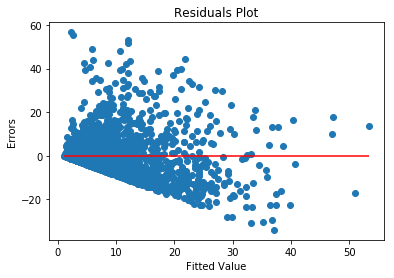

In [20]:
error = test_labels - predictions

plt.scatter(x = predictions, y = error)
plt.hlines(y = 0, xmin=min(predictions), xmax= max(predictions), color='red')
plt.title('Residuals Plot')
plt.xlabel('Fitted Value')
plt.ylabel('Errors')
plt.show

Biased model, since the residuals were not randomly spread out from 0 


In [21]:
print('Random Forest MSE:', np.mean((predictions - test_labels) ** 2))

Random Forest MSE: 88.84384976971872


In [22]:
print('MSError when predicting the mean', np.mean((train_labels.mean() - test_labels) ** 2))

MSError when predicting the mean 114.61597708467924


In [23]:
# Print out the mean absolute error (mae)
abe = abs(predictions - test_labels.values)
print('Mean Absolute Error:', round(np.mean(abe), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (abe / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')


Mean Absolute Error: 6.18 degrees.
Accuracy: -35.0 %.


## Problem:

### The Mean Absolute Percentage Error is greater than 100% 

### The performance of the model is not as good as expected

## How can we improve the model?

### Interpret Model and Report Results

In [24]:
# Visualizing a Single Decision Tree

# Import tools needed for visualization
from sklearn.tree import export_graphviz

#import sys
#!{sys.executable} -m pip install pydot

import pydot


In [25]:
# Pull out one tree from the forest
tree = rf.estimators_[10]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = features, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

Populating the interactive namespace from numpy and matplotlib


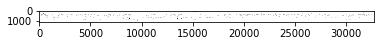

In [26]:
%pylab inline
#import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Visualize the tree
img=mpimg.imread('tree.png')
imgplot = plt.imshow(img)
plt.show()

#### The entire tree is too complicate to visualize 

#### Prune a smaller tree to get the concept 

In [27]:
# Limit depth of tree to 3 levels
rf_small = sklearn.ensemble.RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_data, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = features, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

Populating the interactive namespace from numpy and matplotlib


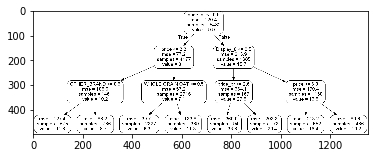

In [28]:
%pylab inline
#import matplotlib.pyplot as plt
#import matplotlib.image as mpimg

# Visualize the tree
img1=mpimg.imread('small_tree.png')
imgplot = plt.imshow(img1)
plt.show()

### Find the Variable Importances

In [29]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(dat, round(importance, 2)) for dat, importance in zip(features, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair))

Variable: price                Importance: 0.29
Variable: vol_eq               Importance: 0.14
Variable: price_pr             Importance: 0.12
Variable: Display_0            Importance: 0.06
Variable: OTHER_BRAND          Importance: 0.03
Variable: REGULAR              Importance: 0.02
Variable: TOASTED              Importance: 0.02
Variable: WHOLE GRAIN OAT      Importance: 0.02
Variable: Feature_A            Importance: 0.02
Variable: Feature_NONE         Importance: 0.02
Variable: GENERAL MILLS        Importance: 0.02
Variable: pr                   Importance: 0.01
Variable: FRUIT                Importance: 0.01
Variable: HONEY                Importance: 0.01
Variable: HONEY NUT            Importance: 0.01
Variable: HONEY ROASTED        Importance: 0.01
Variable: MISSING              Importance: 0.01
Variable: STRAWBERRY           Importance: 0.01
Variable: CORN                 Importance: 0.01
Variable: MULTI GRAIN          Importance: 0.01
Variable: RICE                 Importanc

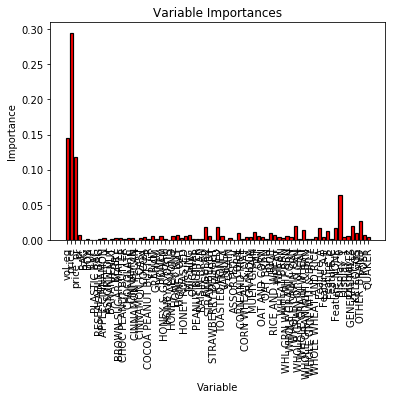

In [30]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, features, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

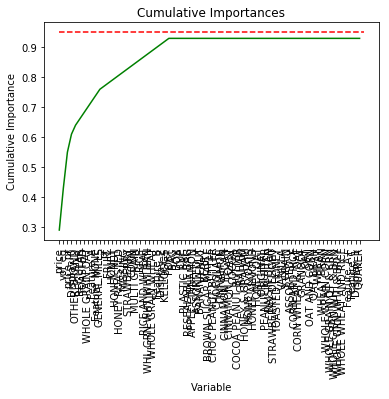

In [31]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [32]:
cumulative_importances

# Cumulative importance stop at 0.94, 
# Find the tuning point

array([0.29, 0.43, 0.55, 0.61, 0.64, 0.66, 0.68, 0.7 , 0.72, 0.74, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93,
       0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93,
       0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93,
       0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93,
       0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93])

### The model stop improving on 94% cummulative importance

In [33]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
tuning = round(max(cumulative_importances),2)
print('Number of features for 94% importance:', np.where(cumulative_importances > tuning)[0][0] + 1)

Number of features for 94% importance: 28


### Remove all variables that have 0 importance

In [34]:
# Extract the names of the least important features
excluded_features = [feature[0] for feature in feature_importances[29:]]


In [35]:
# Exclude non-important data
old_train_data = train_data
new_train_data = old_train_data.drop(excluded_features, axis=1)

old_test_data = test_data
new_test_data = old_test_data.drop(excluded_features, axis = 1)

### Re-train the Random Forest Model with New Training and Testing Dataset 

In [36]:
# # Instantiate Regression Forest model with 1000 decision trees 
rf_1 = sklearn.ensemble.RandomForestRegressor(n_estimators=1000)

# Train the model on training data
rf_1.fit(new_train_data, train_labels)

# Make predictions on test data
predictions_1 = rf_1.predict(new_test_data)

In [37]:
error_1 = test_labels - predictions_1

print('Random Forest MSE:', np.mean(error_1 ** 2))

Random Forest MSE: 90.365618124685


In [38]:
# Print out the mean absolute error (mae)
abe_1 = abs(predictions_1 - test_labels.values)
print('Mean Absolute Error:', round(np.mean(abe), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape_1 = 100 * (abe_1 / test_labels)
# Calculate and display accuracy
accuracy_1 = 100 - np.mean(mape_1)
print('Accuracy:', round(accuracy_1, 2), '%.')


Mean Absolute Error: 6.18 degrees.
Accuracy: -39.02 %.


In [39]:
# Get numerical feature importances
importances = list(rf_1.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(dat, round(importance, 2)) for dat, importance in zip(features, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair)) 

Variable: price                Importance: 0.3
Variable: vol_eq               Importance: 0.18
Variable: price_pr             Importance: 0.13
Variable: HONEY                Importance: 0.07
Variable: HONEY NUT            Importance: 0.03
Variable: ASSORTED_x           Importance: 0.02
Variable: BERRY                Importance: 0.02
Variable: CINNAMON TOAST       Importance: 0.02
Variable: COCOA                Importance: 0.02
Variable: COCOA PEANUT BUTTER  Importance: 0.02
Variable: GRAHAM               Importance: 0.02
Variable: HONEY & OATS         Importance: 0.02
Variable: pr                   Importance: 0.01
Variable: BOX                  Importance: 0.01
Variable: CUP                  Importance: 0.01
Variable: PLASTIC BAG          Importance: 0.01
Variable: RESEALABLE BAG       Importance: 0.01
Variable: APPLE CINNAMON       Importance: 0.01
Variable: BANANA NUT           Importance: 0.01
Variable: BROWN SUGAR MAPLE    Importance: 0.01
Variable: CHOC PEANUT BUTTER   Importance

### Comparing the new dignostic metrics with the original ones, no improvement has been made. 

## LIME

#### Define arguments

In [40]:
# Pre-process 
# Extract varible names
new_feature_names = list(new_train_data.columns)

# Identify the category variable
cat_feature = new_train_data.iloc[:, 3:]

# Extract category variable names
cat_names = list(cat_feature.columns)

#### Define and Run LIME Model

In [41]:
explainer = lime.lime_tabular.LimeTabularExplainer(new_train_data.values, feature_names= new_feature_names, class_names=['UNITS'], categorical_features=cat_feature, categorical_names=cat_names, verbose=True, mode='regression')

In [42]:
# Instead of change pd. Dataframe to np.array, using .values
# Reset Indexes

new_test_data = new_test_data.reset_index(drop = True)
test_labels = test_labels.reset_index(drop=True)

#### Display sample local explainers 

In [43]:
i = 20

exp = explainer.explain_instance(new_test_data.iloc[i,:].values, rf_1.predict, num_features=10)

Intercept 20.73935447413952
Prediction_local [11.15207756]
Right: 8.095483236208233


In [44]:
print('Random Forest Prediction: ', predictions_1[i])
print('Actual: ', test_labels[i])

Random Forest Prediction:  8.095483236208233
Actual:  12.0


In [45]:
exp.show_in_notebook(show_table=True)

In [46]:
i = 100
exp = explainer.explain_instance(new_test_data.iloc[i,:].values, rf_1.predict, num_features=10)

Intercept 17.056138161279666
Prediction_local [11.97303317]
Right: 11.056166666666668


In [47]:
print('Random Forest Prediction: ', predictions_1[i])
print('Actual: ', test_labels[i])

Random Forest Prediction:  11.056166666666668
Actual:  2.0


In [48]:
exp.show_in_notebook(show_table=True)

### Note: LIME's prediction is closed to the random forest's prediction. However, it does not reduce the predict errors. 

How does LIME Select the model? 

## Submodular Pick

#### Maximize the 'coverage' function:

$c(V,W,I) = \sum_{j=1}^{d^{\prime}}{\mathbb{1}_{[\exists i \in V : W_{ij}&amp;gt;0]}I_j}$

$W = \text{Explanation Matrix,  } n\times d^{\prime}$

$V = \text{Set of chosen explanations}$

$I = \text{Global feature importance vector,   } I_j = \sqrt{\sum_i{|W_{ij}|}}$


In [49]:
import warnings
from lime import submodular_pick


In [50]:
sp_obj = submodular_pick.SubmodularPick(explainer, new_train_data.values, rf_1.predict, sample_size=50, num_features=10,num_exps_desired=10)


Intercept 17.167944138912397
Prediction_local [10.97256372]
Right: 9.026939682539679
Intercept 15.165114996418005
Prediction_local [9.01548667]
Right: 5.989821428571429


C:\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.022271e-44
  overwrite_a=True).T


Intercept 21.11379564219891
Prediction_local [3.85487291]
Right: 5.679542063492064
Intercept 20.411124705072808
Prediction_local [7.14910465]
Right: 2.1766500000000004


C:\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.994723e-44
  overwrite_a=True).T


Intercept 16.251520240598634
Prediction_local [14.02482327]
Right: 5.115
Intercept 15.258161680282253
Prediction_local [17.98124563]
Right: 6.625516666666666


C:\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.678387e-45
  overwrite_a=True).T


Intercept 13.059138233257503
Prediction_local [17.9240924]
Right: 10.164542857142857
Intercept 21.425464875782733
Prediction_local [5.84747823]
Right: 7.700444300144304


C:\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.007772e-46
  overwrite_a=True).T


Intercept 13.358653020307463
Prediction_local [13.55607895]
Right: 5.137700000000001


C:\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.022250e-44
  overwrite_a=True).T


Intercept 19.88684055673683
Prediction_local [6.09796642]
Right: 2.227
Intercept 17.339232800975434
Prediction_local [8.37556722]
Right: 9.113909523809523
Intercept 18.283767320532935
Prediction_local [7.85474783]
Right: 6.970650000000001
Intercept 14.850831773584472
Prediction_local [12.48514173]
Right: 5.809
Intercept 19.42416397319644
Prediction_local [7.50771991]
Right: 7.504205158730147
Intercept 20.175197074201712
Prediction_local [11.08539577]
Right: 10.357666666666669


C:\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.589698e-46
  overwrite_a=True).T


Intercept 11.47257395315513
Prediction_local [13.39641283]
Right: 6.160205952380952


C:\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.920793e-44
  overwrite_a=True).T


Intercept 17.948917576649798
Prediction_local [10.4138025]
Right: 13.722005952380954


C:\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.056918e-44
  overwrite_a=True).T


Intercept 14.722194490638053
Prediction_local [10.99815396]
Right: 13.467249999999995
Intercept 19.705119383284078
Prediction_local [13.02447854]
Right: 7.5564904761904765
Intercept 20.831469512304814
Prediction_local [10.91454879]
Right: 3.5307999999999993
Intercept 20.28810615735414
Prediction_local [6.04666067]
Right: 2.1137666666666663
Intercept 19.023880407688345
Prediction_local [10.72518633]
Right: 4.5909713105521925


C:\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.977163e-44
  overwrite_a=True).T


Intercept 10.515427776339294
Prediction_local [15.38027077]
Right: 11.092600000000001
Intercept 9.644958567215117
Prediction_local [17.20703666]
Right: 18.437
Intercept 16.39797584760791
Prediction_local [15.3452198]
Right: 17.0085761904762
Intercept 17.446349576232212
Prediction_local [10.6592617]
Right: 3.41075
Intercept 16.99326722926615
Prediction_local [7.44439575]
Right: 2.6830404678654682
Intercept 18.51939315151807
Prediction_local [7.85571573]
Right: 19.806638708513727
Intercept 18.72029815652546
Prediction_local [9.37389951]
Right: 15.341966666666668


C:\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.946614e-44
  overwrite_a=True).T


Intercept 19.261386941831365
Prediction_local [6.18084543]
Right: 3.713712301587304


C:\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.069484e-44
  overwrite_a=True).T


Intercept 17.18449441785502
Prediction_local [10.94719694]
Right: 2.30206598124098
Intercept 11.950791622506886
Prediction_local [17.26697071]
Right: 7.569080952380953


C:\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.951405e-44
  overwrite_a=True).T


Intercept 21.40912147942813
Prediction_local [6.05552591]
Right: 3.065510353535354
Intercept 15.281169268853056
Prediction_local [13.83879138]
Right: 6.278720454545451


C:\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.616989e-43
  overwrite_a=True).T


Intercept 18.63188208752305
Prediction_local [8.89061297]
Right: 4.853785317460318


C:\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.094437e-44
  overwrite_a=True).T


Intercept 16.189937388505115
Prediction_local [9.90349684]
Right: 8.621664285714301
Intercept 17.14761853609412
Prediction_local [5.44400476]
Right: 4.7351309523809535
Intercept 19.07466264058061
Prediction_local [7.79435848]
Right: 4.692150000000001
Intercept 18.818446170630967
Prediction_local [10.98751495]
Right: 2.4085597652347657


C:\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.611919e-43
  overwrite_a=True).T


Intercept 20.210090805201993
Prediction_local [7.95142918]
Right: 4.707473809523811
Intercept 14.954053995390481
Prediction_local [15.06392199]
Right: 10.660466666666665
Intercept 16.674970982321344
Prediction_local [10.94874104]
Right: 10.930849999999998
Intercept 17.976123965858633
Prediction_local [8.93922572]
Right: 8.957999206349214


C:\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.160285e-44
  overwrite_a=True).T


Intercept 20.396284442049758
Prediction_local [6.17238211]
Right: 3.327798124098122
Intercept 17.879135561198034
Prediction_local [11.06153799]
Right: 14.883475000000017


C:\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.269130e-44
  overwrite_a=True).T


Intercept 15.597463156960622
Prediction_local [11.04196384]
Right: 33.581788095238096
Intercept 20.193314858347087
Prediction_local [8.85479004]
Right: 2.484999999999999
Intercept 14.041804689730396
Prediction_local [17.03561085]
Right: 3.9388095238095198
Intercept 18.718313840194753
Prediction_local [7.5725627]
Right: 2.2716511904761894
Intercept 19.902039129608717
Prediction_local [14.11279731]
Right: 24.035965079365067


C:\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.201708e-44
  overwrite_a=True).T


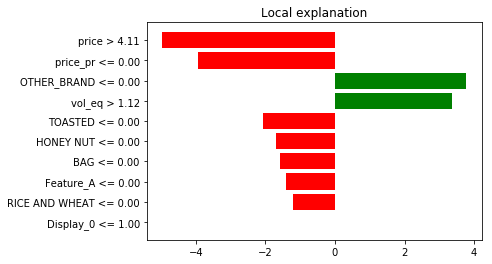

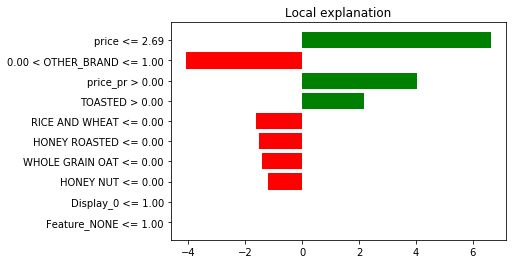

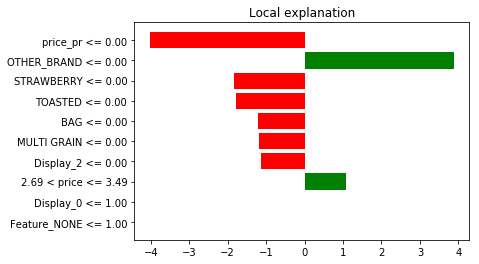

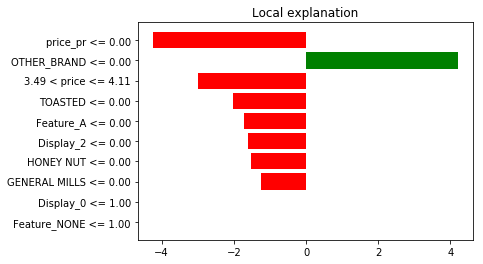

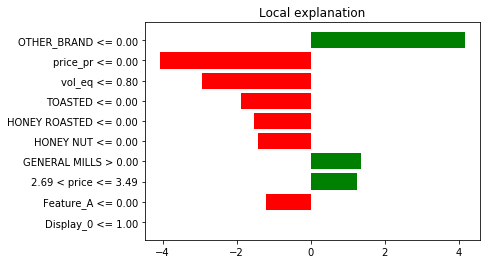

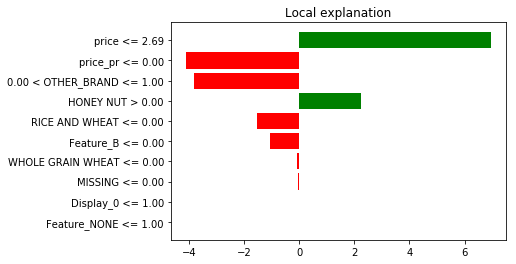

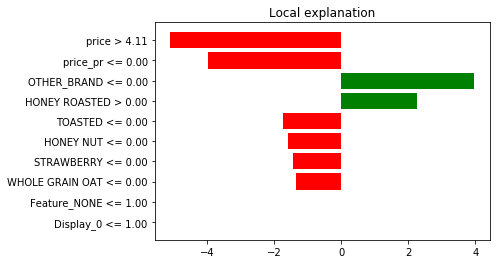

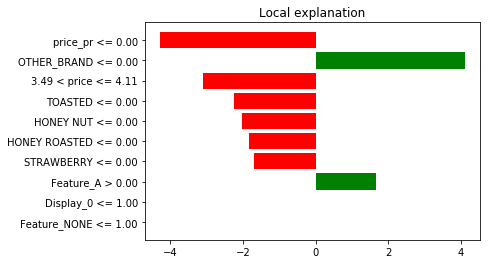

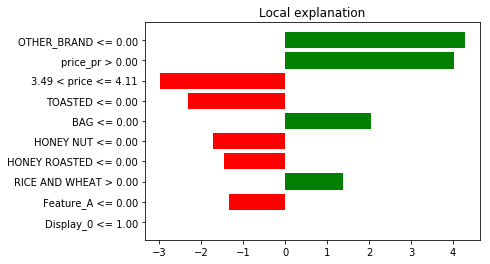

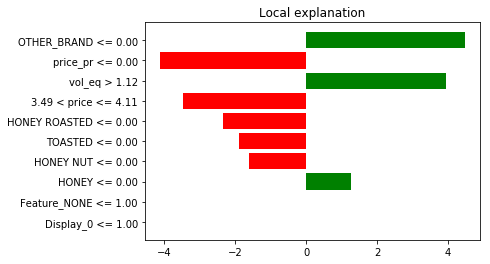

In [51]:
for exp in sp_obj.sp_explanations:
    exp.as_pyplot_figure()

In [52]:

W =pd.DataFrame([dict(this.as_list()) for this in sp_obj.explanations])
W

,0.00 < OTHER_BRAND <= 1.00,2.69 < price <= 3.49,3.49 < price <= 4.11,BAG <= 0.00,Display_0 <= 1.00,Display_2 <= 0.00,Feature_A <= 0.00,Feature_A > 0.00,Feature_B <= 0.00,Feature_NONE <= 1.00,...,TOASTED > 0.00,WHL GRN WHT WHT BRN <= 0.00,WHOLE GRAIN OAT <= 0.00,WHOLE GRAIN WHEAT <= 0.00,price <= 2.69,price > 4.11,price_pr <= 0.00,price_pr > 0.00,vol_eq <= 0.80,vol_eq > 1.12
0,NaN,1.334691,NaN,-1.277569,0.0,NaN,-1.587089,NaN,-1.255297,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-4.116549,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,0.0,NaN,-1.404318,NaN,NaN,0.0,...,1.892107,NaN,NaN,NaN,NaN,-5.309629,-4.097965,NaN,NaN,NaN
2,-4.093336,NaN,NaN,1.771524,0.0,NaN,-1.989453,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-4.482483,NaN,-2.915948,NaN
3,NaN,NaN,-3.354389,NaN,0.0,NaN,-1.852426,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-4.412758,NaN,NaN,NaN
4,-3.986010,NaN,NaN,1.435959,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,6.629977,NaN,-4.166293,NaN,NaN,3.695156
5,-4.465263,NaN,NaN,-2.278813,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,6.672303,NaN,NaN,4.002771,NaN,3.778828
6,-4.201111,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,-1.296484,NaN,6.877929,NaN,NaN,4.087704,NaN,3.758752
7,NaN,NaN,NaN,NaN,0.0,NaN,-1.318741,NaN,NaN,0.0,...,NaN,NaN,-1.522520,NaN,NaN,-5.239396,-4.188857,NaN,NaN,NaN
8,NaN,NaN,-3.089711,NaN,0.0,-1.412987,NaN,NaN,NaN,0.0,...,1.729689,NaN,NaN,NaN,NaN,NaN,NaN,4.174506,NaN,NaN
9,-3.978190,NaN,NaN,NaN,0.0,NaN,-1.698195,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,-5.251729,NaN,3.958551,NaN,NaN


In [53]:
W.columns

Index(['0.00 < OTHER_BRAND <= 1.00', '2.69 < price <= 3.49',
       '3.49 < price <= 4.11', 'BAG <= 0.00', 'Display_0 <= 1.00',
       'Display_2 <= 0.00', 'Feature_A <= 0.00', 'Feature_A > 0.00',
       'Feature_B <= 0.00', 'Feature_NONE <= 1.00', 'GENERAL MILLS <= 0.00',
       'GENERAL MILLS > 0.00', 'HONEY <= 0.00', 'HONEY > 0.00',
       'HONEY NUT <= 0.00', 'HONEY NUT > 0.00', 'HONEY ROASTED <= 0.00',
       'HONEY ROASTED > 0.00', 'MISSING <= 0.00', 'MISSING > 0.00',
       'MULTI GRAIN <= 0.00', 'OTHER_BRAND <= 0.00', 'RICE AND WHEAT <= 0.00',
       'RICE AND WHEAT > 0.00', 'STRAWBERRY <= 0.00', 'TOASTED <= 0.00',
       'TOASTED > 0.00', 'WHL GRN WHT WHT BRN <= 0.00',
       'WHOLE GRAIN OAT <= 0.00', 'WHOLE GRAIN WHEAT <= 0.00', 'price <= 2.69',
       'price > 4.11', 'price_pr <= 0.00', 'price_pr > 0.00', 'vol_eq <= 0.80',
       'vol_eq > 1.12'],
      dtype='object')

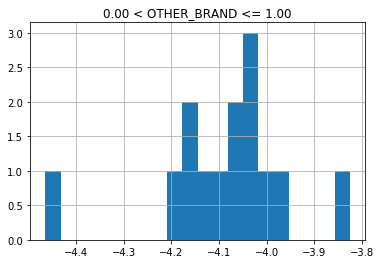

In [54]:
im= W.hist('0.00 < OTHER_BRAND <= 1.00', bins = 20)

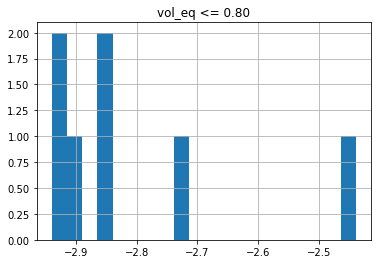

In [55]:
im= W.hist('vol_eq <= 0.80', bins = 20)